# Topic Modeling

By :

>Hussain Alhadab

>Ahmed Alonaizi

>Mohammed Alhamoud

>Feras Alyahya

>Omar Alhadi

In [1]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import adjusted_rand_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from scipy.sparse.linalg import svds
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#!pip install --upgrade ipython


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
import string
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

import pyLDAvis
import pyLDAvis.sklearn
from wordcloud import STOPWORDS, WordCloud
import emoji

from corextopic import corextopic as ct
from corextopic import vis_topic as vt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oalha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\oalha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# EDA & Preprocessing

In [4]:
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    4. Remove stop words
    '''
    stemmer = nltk.stem.WordNetLemmatizer()
#     sw = set(nltk.corpus.stopwords.words("english"))
    
    nopunc = [char for char in text if not emoji.is_emoji(char)] # remove emojis
    nopunc = [char for char in nopunc if char not in string.punctuation] # remove punctuation
    nopunc = ''.join([i for i in nopunc if not i.isdigit()])
    nopunc = [word.lower() for word in nopunc.split() if word.lower() not in STOPWORDS and len(word) > 3]
    nopunc = [re.sub(r'[^\w\s]|_', '', word) for word in nopunc] # remove all unidecode punctuations
    nopunc = [re.sub(r'http\S+', '', word) for word in nopunc] # remove urls
    nopunc = [re.sub(r'www\S+', '', word) for word in nopunc] # remove urls
#     return nopunc
    return [stemmer.lemmatize(word) for word in nopunc]


C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
sample_text = "Hey There! :cara_de_confusión: 😕💙🧹 This is https://stackoverflow.com - 0 _ a Sample review, which 123happens {blah}%456 to contain happened punctuations universal rights of right contained."
print(text_process(sample_text))

C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['caradeconfusión', '', 'sample', 'review', 'happens', 'blah', 'contain', 'happened', 'punctuation', 'universal', 'right', 'right', 'contained']


In [6]:
def elbow(X_transformed, a=4, b=12):
    '''checking for optimal number of clusters'''

    Sum_of_squared_distances = []
    K = range(a,b)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(X_transformed)
        Sum_of_squared_distances.append(km.inertia_)

    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Display topics functions

In [7]:
def display_topics(model, feature_names, no_top_words):
    '''Display topics for NMF, LDA, LSA and KMeans models ONLY'''
    
    if type(model).__name__ == 'KMeans':
        order_centroids = model.cluster_centers_.argsort()[:, ::-1]
        for i in range(model.n_clusters):
            print(f"Topic  {i+1}:"),
            print("   ", end=' ')
            for ind in order_centroids[i, :no_top_words]:
                print(feature_names[ind], end=', '),
            print()        
    else:    
        for topic_idx, topic in enumerate(model.components_):
            print(f"Topic  {topic_idx+1}")
            print("   ", ", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
            print()

C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Import Dataset

In [8]:
# df2 = pd.read_csv("topic_classifier 2.csv" )

C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# Counter(df2.Topic)

C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
#df = pd.read_csv("topic_classifier.csv" )
#df['combine'] = df['title']+ " " + df['body']
#df.dropna(how='any', inplace=True)
#df['cleaned'] = df['combine'].map(text_process)
#df_train = pd.read_csv("train.csv" )
#df_test = pd.read_csv("test.csv" )
df= pd.read_csv("bbc-text.csv" )
#df = pd.concat([df_train, df_test], axis=0)
df.dropna(how='any', inplace=True)
df

C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text
0,tv future in the hands of viewers with home th...
1,worldcom boss left books alone former worldc...
2,tigers wary of farrell gamble leicester say ...
3,yeading face newcastle in fa cup premiership s...
4,ocean s twelve raids box office ocean s twelve...
...,...
2220,cars pull down us retail figures us retail sal...
2221,kilroy unveils immigration policy ex-chatshow ...
2222,rem announce new glasgow concert us band rem h...
2223,how political squabbles snowball it s become c...


In [11]:
#df['combine'] = df['Heading']+ " " + df['Article']
#df['cleaned'] = df['combine'].map(text_process)
df['cleaned'] = df['text'].map(text_process)
df

C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,cleaned
0,tv future in the hands of viewers with home th...,"[future, hand, viewer, home, theatre, system, ..."
1,worldcom boss left books alone former worldc...,"[worldcom, bos, left, book, alone, former, wor..."
2,tigers wary of farrell gamble leicester say ...,"[tiger, wary, farrell, gamble, leicester, will..."
3,yeading face newcastle in fa cup premiership s...,"[yeading, face, newcastle, premiership, side, ..."
4,ocean s twelve raids box office ocean s twelve...,"[ocean, twelve, raid, office, ocean, twelve, c..."
...,...,...
2220,cars pull down us retail figures us retail sal...,"[car, pull, retail, figure, retail, sale, fell..."
2221,kilroy unveils immigration policy ex-chatshow ...,"[kilroy, unveils, immigration, policy, exchats..."
2222,rem announce new glasgow concert us band rem h...,"[announce, glasgow, concert, band, announced, ..."
2223,how political squabbles snowball it s become c...,"[political, squabble, snowball, become, common..."


# Corpus
Corpus is containing documents 

In [12]:
corpus = df['cleaned'].apply(lambda x: ' '.join(x))
corpus

C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0       future hand viewer home theatre system plasma ...
1       worldcom bos left book alone former worldcom b...
2       tiger wary farrell gamble leicester will rushe...
3       yeading face newcastle premiership side newcas...
4       ocean twelve raid office ocean twelve crime ca...
                              ...                        
2220    car pull retail figure retail sale fell januar...
2221    kilroy unveils immigration policy exchatshow h...
2222    announce glasgow concert band announced plan p...
2223    political squabble snowball become commonplace...
2224    souness delight euro progress bos graeme soune...
Name: cleaned, Length: 2225, dtype: object

# TF-IDF Vectorizer Matrix

In [13]:
# tfidf_vector = TfidfVectorizer(analyzer=text_process)

#ngram_range=(1,3)

tfidf_vector = TfidfVectorizer()
X_tfidf = tfidf_vector.fit_transform(corpus)

C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
X_tfidf

C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<2225x26251 sparse matrix of type '<class 'numpy.float64'>'
	with 299786 stored elements in Compressed Sparse Row format>

In [15]:
len(tfidf_vector.vocabulary_)

C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


26251

# Latent Semantic Analysis (LSA)

In [16]:
lsa = TruncatedSVD(10)
X_lsa = lsa.fit_transform(X_tfidf)
# the percentage of variance that is attributed by each of the selected components/topics
lsa.explained_variance_ratio_

C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([0.00286272, 0.01069207, 0.00917047, 0.00819615, 0.00775233,
       0.00551817, 0.00479299, 0.00452628, 0.00443591, 0.00429096])

In [17]:
display_topics(lsa, tfidf_vector.get_feature_names(), 15)

C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic  1
    said, will, year, people, labour, game, election, government, film, party, blair, brown, tory, time, world

Topic  2
    labour, election, blair, party, tory, brown, minister, government, howard, chancellor, prime, conservative, leader, plan, campaign

Topic  3
    film, award, best, england, labour, oscar, blair, game, actor, election, star, party, wale, brown, tory

Topic  4
    film, award, best, oscar, actor, actress, nomination, festival, music, aviator, director, movie, comedy, star, category

Topic  5
    economy, growth, rate, bank, economic, price, dollar, year, rise, china, quarter, film, sale, economist, export

Topic  6
    yukos, court, company, firm, russian, software, lord, said, gazprom, case, legal, yugansk, rosneft, russia, security

Topic  7
    software, microsoft, program, virus, search, user, email, site, security, computer, spyware, window, england, spam, film

Topic  8
    mobile, phone, film, england, wale, ireland, handset, lord, robinson, nation,

#  LSA Result 
### We can notice that topics are:

>Topic 1: Politics || Topic 2: Politics || Topic 3: Film industry || Topic 4: Film industry || Topic 5: Economy || Topic 6: Legal || Topic 7: Technology|| Topic 8: Technology || Topic 9: Sports ||Topic 10: Sports


# Comparison

In [43]:
#The Vt matrix shows us the documents we started with, and how each document is made up of the resulting topics

documents = df.text.copy()#df.cleaned.copy()#df.text.copy()

Vt = pd.DataFrame(X_lsa.round(3),
             index = documents,
             columns = ["Politics","Politics","Film industry","Film industry","Economy","Legal","Technology","Technology","Sports","Music industry" ])

Vt.sample(3)

C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Politics,Politics,Film industry,Film industry,Economy,Legal,Technology,Technology,Sports,Music industry
text,,,,,,,,,,
buyers snap up jet airways shares investors have snapped up shares in jet airways india s biggest airline following the launch of its much anticipated initial public offer (ipo). the ipo for 17.3 million shares was fully sold within 10 minutes of opening on friday. analysts expect jet to raise at least 16.4bn rupees ($375m; £198m) from the offering. interest in jet s ipo has been fuelled by hopes for robust growth in india s air travel market. the share offer representing about 20% of jet s equity was oversubscribed news agency reuters reported. jet which was founded by london-based travel agent naresh goyal plans to use the cash to buy new planes and cut its debt. the company has grown rapidly since it launched operations in 1993 overtaking state-owned flag carrier indian airlines. however it faces stiff competition from rivals and low-cost carriers. jet s ipo is the first in a series of expected share offers from indian companies this year as they move to raise funds to help them do business in a rapidly-growing economy.,0.142,-0.023,-0.115,-0.006,0.112,0.045,-0.057,0.022,-0.059,0.039
wenger shock at newcastle dip arsenal manager arsene wenger has admitted he is at a loss to explain why newcastle are languishing in the bottom half of the table. the gunners travel to st james park on wednesday with newcastle 14th in the premiership after a troubled season. and wenger said: at the beginning of the season you would expect them to be fighting for the top four. i don t know how they got to be where they are. it looks to me from the outside that they have many injuries. arsenal go into the game on the back of a 2-0 victory over fulham on sunday. and wenger added: the best way to prepare for a game is to win the previous one. we will go to newcastle in good shape. fatigue won t play too big a part in the next few weeks as we have players coming back so i can rotate a bit more. we do not play a season with 11 players and i believe that all of our squad deserve a chance in the team. striker thierry henry along with robert pires scored against fulham. and henry afterwards described the display as beautiful to watch . he said: what matters is winning and the three points of course. that is the only thing that really matters. but it is more enjoyable when you play like we did against fulham. we are playing as a team and that is important because there were some games when we maybe were not there as a team and suffered for that. those were games we lost.,0.155,-0.109,0.125,-0.181,-0.037,-0.032,-0.003,-0.026,-0.073,0.159
watchdog probes e-mail deletions the information commissioner says he is urgently asking for details of cabinet office orders telling staff to delete e-mails more than three months old. richard thomas totally condemned the deletion of e-mails to prevent their disclosure under freedom of information laws coming into force on 1 january. government guidance said e-mails should only be deleted if they served no current purpose mr thomas said. the tories and the lib dems have questioned the timing of the new rules. tory leader michael howard has written to tony blair demanding an explanation of the new rules on e-mail retention. on monday lib dem constitutional affairs committee chairman alan beith warned that the deletion of millions of government e-mails could harm the ability of key probes like the hutton inquiry. the timing of the new rules just before the freedom of information act comes into forces was too unlikely to have been a coincidence mr beith said. but a cabinet office spokeswoman said the move was not about the new laws or the destruction of important records . mr beith urged the information commissioner to look at how the e-mail regime could support the freedom of information regime . mr thomas said: the new act of parliament makes it very clear that to destroy records in order to prevent thei

# Non-Negative Matrix Factorization (NMF)

In [19]:
#nmf = NMF(n_components=4, random_state=0)
nmf= NMF(7)
nmf.fit_transform(X_tfidf)

C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\oalha\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


array([[0.10606181, 0.01296309, 0.00451534, ..., 0.00103791, 0.00237893,
        0.05920838],
       [0.00440347, 0.        , 0.01219735, ..., 0.        , 0.10828928,
        0.00194567],
       [0.0013607 , 0.00852903, 0.09072792, ..., 0.00391243, 0.00198098,
        0.00445325],
       ...,
       [0.0245702 , 0.00871397, 0.02859568, ..., 0.00867782, 0.00957835,
        0.        ],
       [0.00317655, 0.04947436, 0.01708226, ..., 0.0052106 , 0.00929084,
        0.01683334],
       [0.00132651, 0.00866823, 0.0908191 , ..., 0.00749858, 0.        ,
        0.        ]])

In [20]:
display_topics(nmf, tfidf_vector.get_feature_names(), 15)

Topic  1
    mobile, phone, music, technology, digital, people, gadget, service, device, will, video, broadband, game, camera, handset

Topic  2
    labour, election, blair, party, tory, brown, said, howard, minister, government, chancellor, prime, will, plan, conservative

Topic  3
    game, england, player, will, wale, match, said, team, ireland, play, side, injury, rugby, club, champion

Topic  4
    film, award, best, oscar, actor, star, actress, festival, nomination, director, aviator, prize, year, comedy, movie

Topic  5
    growth, economy, rate, price, economic, year, bank, said, market, rise, dollar, figure, quarter, sale, china

Topic  6
    yukos, court, russian, company, gazprom, firm, yugansk, rosneft, russia, bankruptcy, said, auction, deutsche, khodorkovsky, case

Topic  7
    software, microsoft, user, program, site, virus, email, search, computer, security, said, people, system, window, information



C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# NMF Result 
### We can notice that topics are:


>Topic 1: Technology || Topic 2:Politics || Topic 3:Sports || Topic 4: Film industry || Topic 5:Economy || Topic 6: Legal  || Topic 7: Technology




# Comparison

In [21]:
#The Vt matrix shows us the documents we started with, and how each document is made up of the resulting topics

documents = df.text.copy() #df.cleaned.copy()#df.text.copy()

doc_topic=nmf.fit_transform(X_tfidf)
Vt = pd.DataFrame(doc_topic.round(3),
             index = documents,
             columns = ["Technology","Politics","Sports"," Film industry ","Economy","Legal","Technology"])
Vt.sample(3)

C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\oalha\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


,Technology,Politics,Sports,Film industry,Economy,Legal,Technology
text,,,,,,,
us hacker breaks into t-mobile a man is facing charges of hacking into computers at the us arm of mobile phone firm t-mobile. the californian man nicholas lee jacobsen was arrested in october. mr jacobsen tried at least twice to hack t-mobile s network and took names and social security numbers of 400 customers said a company spokesman. the arrest came a year after t-mobile uncovered the unauthorised access. the us secret service has been investigating the case. t-mobile has stringent procedures in place where we monitor for suspicious activity so that limited his activities and we were able to take corrective action immediately peter dobrow a t-mobile spokesperson said. it is thought that mr jacobsen s hacking campaign took place over at least seven months during which time he read e-mails and personal computer files according to court records. although mr jacobsen 21 managed to get hold of some data it is thought he failed to get customer credit card numbers which are stored on a separate computer system said mr dobrow. t-mobile confirmed that the us secret service was also looking into whether the hacker accessed photos that t-mobile subscribers had taken with their camera phones. the associated press agency reported that mr jacobsen also read personal files on the secret service agent who was apparently investigating the case. a los angeles grand jury indicted mr jacobsen with intentionally accessing a computer system without authorisation and with the unauthorised impairment of a protected computer between march and october 2004. he is currently on bail. t-mobile is a subsidiary company of deutsche telekom and has about 16.3 million subscribers in the us.,0.034,0.00,0.0,0.000,0.000,0.024,0.064
house prices suffer festive fall uk house prices fell 0.7% in december according to figures from the office of the deputy prime minister. nationally house prices rose at an annual rate of 10.7% in december less than the 13.7% rise the previous month. the average uk house price fell from £180 126 in november to £178 906 reflecting recent land registry figures confirming a slowdown in late 2004. all major uk regions apart from northern ireland experienced a fall in annual growth during december. december is traditionally a quiet month for the housing market because of christmas celebrations. however recent figures from the land registry - showing a big drop in sales between the last quarter of 2004 and the previous year - suggested the slowdown could be more than a seasonal blip. the volume of sales between october and december dropped by nearly a quarter from the same period in 2003 the land registry said. although both the office of the deputy prime minister (odpm) and the land registry figures point to a slowdown in the market the most recent surveys from nationwide and halifax have indicated the market may be undergoing a revival. after registering falls at the back-end of 2004 halifax said house prices rose by 0.8% in january and nationwide reported a rise of 0.4% in the first month of the year.,0.000,0.00,0.0,0.000,0.174,0.000,0.000
more power to the people says hp the digital revolution is focused on letting people tell and share their own stories according to carly fiorina chief of technology giant hewlett packard. the job of firms such as hp now she said in a speech at the consumer electronics show (ces) was to ensure digital and physical worlds fully converged. she said the goal for 2005 was to make people the centre of technology. ces showcases 50 000 new gadgets that will be hitting the shelves in 2005. the tech-fest the largest of its kind in the world runs from 6 to 9 january. the digital revolution is about the democratisation of technology and the experiences it makes possible she told delegates. revolution has always been about giving power to the people. she added: the real story of the digital revolution is not just new products but the m

# KMeans

In [22]:
km = KMeans(n_clusters=10,random_state=10,n_init=1) # n_init, number of times the K-mean algorithm will run
km.fit(X_tfidf)

display_topics(km, tfidf_vector.get_feature_names(), 20)

C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic  1:
    music, game, album, band, chart, gadget, song, single, player, will, said, video, sony, number, console, sale, digital, nintendo, gaming, device, 
Topic  2:
    labour, election, party, blair, tory, said, brown, government, howard, minister, lord, chancellor, prime, will, plan, conservative, people, leader, campaign, kennedy, 
Topic  3:
    phone, mobile, user, people, software, said, service, technology, computer, broadband, site, will, network, system, program, microsoft, search, firm, virus, email, 
Topic  4:
    award, best, film, oscar, nomination, actor, prize, ceremony, category, actress, aviator, winner, named, year, nominated, star, director, foxx, comedy, nominee, 
Topic  5:
    economy, growth, rate, economic, price, dollar, said, bank, year, market, rise, figure, deficit, spending, export, economist, quarter, month, consumer, china, 
Topic  6:
    yukos, deutsche, boerse, russian, gazprom, yugansk, rosneft, russia, euronext, khodorkovsky, court, bankruptcy, au

In [23]:
elbow(X_tfidf, 5, 10)

C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-6-ae63572e832c>:15: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


## Adding KMeans Result to Dataset
### We can notice that topics are:

>Cluster 1: Music industry || Cluster 2: Governments and Politics || Cluster 3: Technology || Cluster 4: Film industry || Cluster 5: Economy ||Cluster 6: Companies & Businesses ||Cluster 7: Sports||Cluster 8:Sports ||Cluster 9: Companies & Businesses ||Cluster 10: Film industry



In [24]:
prediction = km.predict(X_tfidf)

df["Topic_KMeans"] = prediction

#df.Topic_KMeans.replace({1: "Music industry", 2:"Governments and Politics", 3:"Technology", 4:"Film industry", 5:"Economy" , 6: 'Companies & Businesses',7:'Sports',8:'Sports',9:'Companies & Businesses ',10:'Film industry'}, inplace=True)
df.Topic_KMeans.replace({0: "Music industry", 1:"Governments and Politics", 2:"Technology", 3:"Film industry", 4:"Economy" , 5: 'Companies & Businesses',6:'Sports',7:'Sports',8:'Companies & Businesses ',9:'Film industry'}, inplace=True)

C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
df.sample(10)

C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,cleaned,Topic_KMeans
1401,brazil plays down varig rescue the brazilian g...,"[brazil, play, varig, rescue, brazilian, gover...",Companies & Businesses
115,byrds producer melcher dies at 62 record produ...,"[byrd, producer, melcher, dy, record, producer...",Companies & Businesses
1834,school sport is back says pm tony blair has...,"[school, sport, back, say, tony, blair, promis...",Companies & Businesses
664,no uk premiere for rings musical the producers...,"[premiere, ring, musical, producer, behind, lo...",Film industry
2010,fast moving phone bugs appear security firms a...,"[fast, moving, phone, bug, appear, security, f...",Technology
2120,ferguson rues failure to cut gap boss sir alex...,"[ferguson, rue, failure, bos, alex, ferguson, ...",Sports
2198,asian banks halt dollar s slide the dollar reg...,"[asian, bank, halt, dollar, slide, dollar, reg...",Economy
1993,parmalat bank barred from suing bank of americ...,"[parmalat, bank, barred, suing, bank, america,...",Companies & Businesses
1421,roddick splits from coach gilbert andy roddick...,"[roddick, split, coach, gilbert, andy, roddick...",Sports
1027,uk coal plunges into deeper loss shares in uk ...,"[coal, plunge, deeper, loss, share, coal, fall...",Companies & Businesses


# Count Vectorizer
Matrix of token counts

In [26]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X_tf = tf_vectorizer.fit_transform(corpus)

C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Latent Dirichlet Allocation (LDA)

In [27]:
lda_no_topics = 8

lda = LatentDirichletAllocation(n_components=lda_no_topics, random_state=0)
lda.fit_transform(X_tf)

C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[4.24623868e-04, 4.24039959e-04, 1.99237817e-02, ...,
        4.24418686e-04, 4.24355923e-04, 4.24350999e-04],
       [8.28571000e-04, 8.28866317e-04, 8.28310360e-04, ...,
        7.76909031e-01, 8.28867833e-04, 2.18118065e-01],
       [1.31809540e-03, 1.17525703e-01, 1.31719438e-03, ...,
        1.31743298e-03, 1.31739077e-03, 1.31761889e-03],
       ...,
       [9.34621749e-04, 9.35027182e-04, 5.97848471e-01, ...,
        9.34439461e-04, 6.89048399e-02, 2.63083844e-01],
       [4.10345647e-04, 3.29192940e-01, 4.10688261e-04, ...,
        2.92593615e-01, 4.10523909e-04, 3.98606721e-03],
       [1.48940433e-03, 1.49037855e-03, 1.48992773e-03, ...,
        2.28949815e-02, 1.49014455e-03, 1.49029453e-03]])

In [28]:
display_topics(lda, tf_vectorizer.get_feature_names(), 15)

Topic  1
    film, said, best, award, actor, director, year, star, party, oscar, british, actress, london, role, ukip

Topic  2
    said, open, match, year, game, final, play, test, world, roddick, australian, injury, second, champion, number

Topic  3
    music, said, song, band, year, album, people, number, search, site, single, chart, record, radio, artist

Topic  4
    said, people, game, technology, government, year, make, time, lord, digital, work, want, right, video, home

Topic  5
    game, said, england, player, club, wale, ireland, team, time, rugby, play, chelsea, minute, united, good

Topic  6
    said, people, labour, election, party, service, blair, tory, brown, phone, mobile, government, minister, user, year

Topic  7
    year, film, world, said, best, time, award, second, record, race, title, book, star, olympic, event

Topic  8
    said, year, company, market, firm, sale, bank, price, growth, share, economy, month, economic, rate, analyst



C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# LDA Result 
### We can notice that topics are:
 
>Topic 1:Film industry || Topic 2:Sports || Topic 3:music || Topic 4:Technology || Topic 5 :Sports || Topic 6: Governments and Politics || Topic 7: Film industry || Topic 8:economy


# Top Most Relevant Terms for each Topic

In [29]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, X_tf, tf_vectorizer, mds='tsne')
panel

C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\oalha\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3     -108.958252 -208.941483       1        1  21.545043
5      186.487061  -98.103249       2        1  20.953104
7       19.245832  160.858780       3        1  17.927681
4      170.658829   75.445076       4        1  11.978520
0       -1.386411  -35.043739       5        1   9.002354
2     -145.800095  106.944611       6        1   6.631166
6       64.834541 -221.825272       7        1   6.320442
1     -196.906036  -58.990913       8        1   5.641689, topic_info=           Term         Freq        Total Category  logprob  loglift
5028       film  1042.000000  1042.000000  Default  30.0000  30.0000
8801      music   791.000000   791.000000  Default  29.0000  29.0000
5494       game  1423.000000  1423.000000  Default  28.0000  28.0000
1278       best   874.000000   874.000000  Default  27.0000  27.0000
965       award   556.000000   556.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
10768    really    71.795013   365.099932   Topic8  -5.7095   1.2486
14636      week    75.817367   754.828768   Topic8  -5.6550   0.5768
13602     title    65.900722   305.997124   Topic8  -5.7952   1.3396
4801       face    65.663678   334.811072   Topic8  -5.7988   1.2460
3379   decision    66.174175   400.625199   Topic8  -5.7911   1.0743

[595 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
0          7  0.950732      aaa
53         1  0.048812  academy
53         4  0.012203  academy
53         5  0.903019  academy
53         8  0.024406  academy
...      ...       ...      ...
14979      3  0.997527    yukos
14992      4  0.894838  zealand
14992      5  0.020810  zealand
14992      7  0.020810  zealand
14992      8  0.062431  zealand

[1566 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 8, 5, 1, 3, 7, 2])

# Evaluate LDA model

In [30]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda.score(X_tf))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(X_tf))

# See model parameters
# pprint(lda.get_params())

C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Log Likelihood:  -3095816.048166363
Perplexity:  3173.4254330978147


In [31]:
# wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tf_vectorizer.get_feature_names())
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# CorEx

In [32]:
import numpy as np
from corextopic import corextopic as ct
from corextopic import vis_topic as vt

words = list(np.asarray(tf_vectorizer.get_feature_names()))

corex = ct.Corex(n_hidden=8, words=words, seed=1)
corex.fit(X_tf, words=words, docs=corpus)

C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
topics = corex.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n+1) + ', '.join(topic_words))

1: star, game, coach, champion, yearold, match, award, injury, play, season
2: user, technology, computer, digital, online, software, device, website, video, internet
3: tory, labour, conservative, election, party, blair, liberal, tony, leader, democrat
4: firm, market, company, analyst, share, growth, consumer, business, price, product
5: england, rugby, wale, ball, ireland, thing, think, chance, know, robinson
6: government, minister, secretary, prime, public, plan, political, country, claim, proposal
7: storage, operator, handset, audio, fast, known, downloading, increasingly, useful, easier
8: economy, economic, bank, rate, economist, forecast, rise, higher, level, inflation


C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# CorEx Result 
### We can notice that topics are:

>Topic 1: Sports || Topic 2: Technology || Topic 3:Politics || Topic 4:Businesses || Topic 5: Sports || Topic 6: Politics || Topic 7: Technology || Topic 8: Economy 


In [34]:
plt.figure(figsize=(10,5))
plt.bar(range(corex.tcs.shape[0]), corex.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Gensim LDA

In [35]:
from gensim.models import LdaModel, LdaMulticore, CoherenceModel
from gensim import matutils, corpora
from pprint import pprint

# Convert sparse matrix of counts to a gensim corpus
# gensim_corpus = matutils.Sparse2Corpus(X_tf.transpose())

#create dictionary
# id2word = dict((v, k) for k, v in tf_vectorizer.vocabulary_.items())
              
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(df.cleaned)

# convert tokenized documents into a document-term matrix
corpus22 = [dictionary.doc2bow(text) for text in df.cleaned]
    
k = 7
gensim_lda = LdaModel(corpus22, num_topics = k, id2word = dictionary, random_state = 1, passes=10)

pprint(gensim_lda.show_topics())

C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\oalha\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


[(0,
  '0.010*"said" + 0.010*"will" + 0.008*"game" + 0.008*"england" + '
  '0.007*"player" + 0.006*"wale" + 0.004*"ireland" + 0.004*"last" + '
  '0.004*"year" + 0.004*"world"'),
 (1,
  '0.015*"said" + 0.007*"goal" + 0.005*"player" + 0.005*"game" + '
  '0.005*"arsenal" + 0.005*"united" + 0.005*"league" + 0.005*"chelsea" + '
  '0.004*"lord" + 0.004*"time"'),
 (2,
  '0.017*"said" + 0.013*"year" + 0.008*"will" + 0.007*"film" + 0.006*"award" + '
  '0.006*"sale" + 0.005*"best" + 0.005*"market" + 0.005*"price" + '
  '0.004*"dollar"'),
 (3,
  '0.018*"will" + 0.014*"said" + 0.012*"game" + 0.010*"people" + '
  '0.007*"technology" + 0.007*"search" + 0.006*"time" + 0.005*"video" + '
  '0.005*"user" + 0.005*"digital"'),
 (4,
  '0.019*"said" + 0.008*"will" + 0.006*"people" + 0.006*"company" + '
  '0.006*"government" + 0.005*"firm" + 0.004*"country" + 0.004*"year" + '
  '0.004*"report" + 0.004*"say"'),
 (5,
  '0.021*"said" + 0.012*"party" + 0.011*"will" + 0.011*"labour" + '
  '0.011*"blair" + 0.010*"

# Gensim LDA Result
We can notice that topics are:
>Topic 1:Sports || Topic 2:Sports || Topic 3: Film industry || Topic 4:Technology || Topic 5 : Companies & Businesses || Topic 6: Politics || Topic 7: Technology 



# Evaluate Gensim LDA model

In [36]:
#score ginsim 
coherencemodel = CoherenceModel(model=gensim_lda, texts=df.cleaned, dictionary=dictionary, coherence='c_v')
print(coherencemodel.get_coherence())

C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.4699494801304806


# Top Most Relevant Terms for each Topic

In [37]:
import pyLDAvis.gensim_models

# lda_corpus = gensim_lda[gensim_corpus]

panel2 = pyLDAvis.gensim_models.prepare(gensim_lda, corpus22, dictionary, mds='tsne')
panel2

C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\oalha\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2     -29.594002  60.112713       1        1  20.818155
4     -45.996586  11.891685       2        1  18.130501
0      20.368856  70.019325       3        1  15.148818
5      53.928768  31.704309       4        1  14.746090
3     -12.437127 -26.423267       5        1  12.752279
6       3.965971  21.797720       6        1  11.562725
1      37.524284 -16.517805       7        1   6.841433, topic_info=        Term         Freq        Total Category  logprob  loglift
716   labour   733.000000   733.000000  Default  30.0000  30.0000
129   mobile   805.000000   805.000000  Default  29.0000  29.0000
359     game  1389.000000  1389.000000  Default  28.0000  28.0000
732    party   823.000000   823.000000  Default  27.0000  27.0000
306    phone   748.000000   748.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
293     made    87.021924   792.194025   Topic7  -5.8260   0.4735
150     play    84.021205   621.419280   Topic7  -5.8611   0.6812
341     back    82.877628   718.807115   Topic7  -5.8748   0.5219
507   second    81.238060   570.020700   Topic7  -5.8948   0.7339
1324   point    76.241018   354.463464   Topic7  -5.9583   1.1455

[541 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
10548      6  0.958757     abbas
5447       1  0.967468   academy
5447       2  0.024390   academy
5447       5  0.008130   academy
1412       3  0.973814  accident
...      ...       ...       ...
230        6  0.103443      year
230        7  0.023964      year
4317       2  0.166342     yukos
4317       6  0.818913     yukos
3625       3  0.994544   zealand

[1303 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 1, 6, 4, 7, 2])

# Most 100 common word

C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


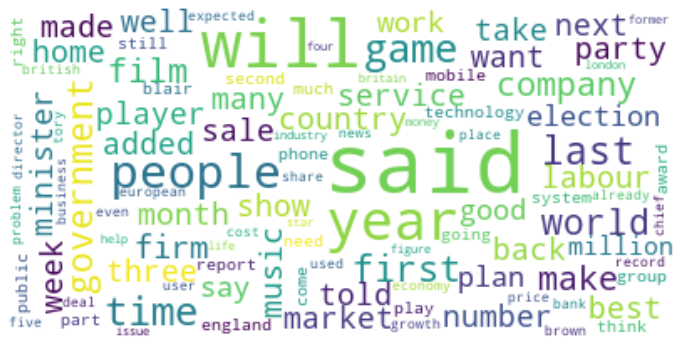

In [38]:
#most 30 commonn word in the data set

%matplotlib inline
from nltk.probability import FreqDist

#iterate through each tweet, then each token in each tweet, and store in one list
flat_words = [item for sublist in df['cleaned'] for item in sublist]
word_freq = FreqDist(flat_words)
# word_freq.most_common(30)

#retrieve word and count from FreqDist tuples

most_common_count = [x[1] for x in word_freq.most_common(100)]
most_common_word = [x[0] for x in word_freq.most_common(100)]

#create dictionary mapping of word count
top_30_dictionary = dict(zip(most_common_word, most_common_count))


wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(top_30_dictionary)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

 # Predictions using best model + Testing

In [39]:
line = "One in five companies admit to spying on remote workers without their knowledge"
line = " ".join(text_process(line))
new = tfidf_vector.transform([line])
km.predict(new)

C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([8])

# Recommendations

In [40]:
pd.set_option('display.max_colwidth', 100)  # To display a very long headline completely use None

C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
from sklearn.metrics import adjusted_rand_score, pairwise_distances
import numpy as np
# credit: Kaggle/VIKASHRAJLUHANIWAL 
def tfidf_based_model_id(row_index, num_similar_items):
    '''Recommedations based on exising article'''
    
    couple_dist = pairwise_distances(X_tfidf, X_tfidf[row_index])
    indices = np.argsort(couple_dist.ravel())[0:num_similar_items+1]
    df2 = pd.DataFrame({
        'headline': df['text'][indices].values,
        'Euclidean similarity with the queried article': couple_dist[indices].ravel()})

    print("="*30, "Queried article details", "="*30)
    print('headline : ', df['text'][indices[0]])
    print("\n", "="*25, "Recommended articles : ", "="*23)

    return pd.DataFrame(df2.iloc[1:, :])

#docment number 50 ,segeggst 10 topic simmiler
tfidf_based_model_id(40, 10)

============================== Queried article details ==============================
headline :  labour targets  hardcore truants  a fresh crackdown on persistent truants in england has been launched by education secretary ruth kelly.  serial truants make up one in 13 pupils. previous initiatives brought 40 000 pupils back to school since 1997  according to official statistics. parenting contracts  penalty notices and  fast track  prosecution systems have been used to tackle what has been a stubborn problem. it is thought that nearly half a million children skip school each day. tories say labour s previous success regarding the issue came because it tackled the easy part of the problem by reducing authorised absence  where parents are permitted to take children out of school. such absences are often due to family holidays.  however  serial truants avoid the classroom despite government schemes costing £885m. those missing classes are more likely to become involved in crime as well as

C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,headline,Euclidean similarity with the queried article
1,blair joins school sailing trip the prime minister has donned a life jacket and joined school ch...,1.177945
2,kelly trails new discipline power teachers could get more powers to remove unruly pupils from cl...,1.223273
3,school sport is back says pm tony blair has promised that sport is back as a priority for s...,1.243559
4,schools to take part in mock poll record numbers of schools across the uk are to take part in a ...,1.269675
5,schools to take part in mock poll record numbers of schools across the uk are to take part in a ...,1.269675
6,tories pledge free sports lessons children would be offered two hours free sports training a we...,1.281005
7,pupils to get anti-piracy lessons lessons on music piracy and copyright issues are to be taught ...,1.283174
8,research fears over kelly s views scientists have expressed concerns that new education secretar...,1.288923
9,faith schools citizenship warning schools must improve the quality of citizenship lessons - or s...,1.293649
10,student inequality exposed teenagers from well-off backgrounds are six times more likely to go...,1.298162


In [42]:
def tfidf_based_model_line(line, num_similar_items):
    '''Recommendations based on new article that not in dataset'''

    line = " ".join(text_process(line))
    new = tfidf_vector.transform([line])
#     print(new)
    
    couple_dist = pairwise_distances(X_tfidf, new)
    indices = np.argsort(couple_dist.ravel())[0:num_similar_items]
    df2 = pd.DataFrame({
        'headline': df['text'][indices].values,
        'Euclidean similarity with the queried article': couple_dist[indices].ravel()})

    print("="*30, "Queried article details", "="*30)
    print('headline : ', line)
    print("\n", "="*25, "Recommended articles : ", "="*23)

    return pd.DataFrame(df2.iloc[:,:])

#docment is my text ,segeggst 10 topic simmiler
line = "One in five companies admit to spying on remote workers without their knowledge"
tfidf_based_model_line(line, 10)

============================== Queried article details ==============================
headline :  five company admit spying remote worker without knowledge

 ========================= Recommended articles :  =======================


C:\Users\oalha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,headline,Euclidean similarity with the queried article
0,talks aim to avert pension strike talks aimed at averting a series of national strikes over pens...,1.327003
1,talks aim to avert pension strike talks aimed at averting a series of national strikes over pens...,1.327003
2,stalemate in pension strike talks talks aimed at averting national strikes over pension reforms ...,1.328556
3,brazil approves bankruptcy reform a major reform of brazil s bankruptcy laws has been approved b...,1.336691
4,millions to lose textile jobs millions of the world s poorest textile trade workers will lose ...,1.351481
5,pension hitch for long-living men male life expectancy is much higher than originally estimated ...,1.351824
6,protect whistleblowers tuc says the government should change the law to give more protection to...,1.355355
7,civil servants in strike ballot the uk s biggest civil service union is to ballot its 290 000 me...,1.357791
8,russian ex-spy on hunger strike an ex-russian intelligence officer who risked his life spying fo...,1.357847
9,call for action on internet scam phone companies are not doing enough to warn customers about in...,1.358449
